In [1]:
import pyarrow.parquet as pq
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

2021-12-06 14:37:33.607344: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-06 14:37:33.607366: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_parquet("Skim_TauTau.parquet")

In [3]:
df["label"] = 0
df = df[df['weight']>0]

In [4]:
print(df)

         weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2  \
0      0.000025  1.151401  2.699523   1.979170    1.137842  1.603054   
1      0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574   
2      0.000025  1.871283  1.047394   2.573060    0.773788  0.890115   
3      0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298   
4      0.000025  0.276418  0.034514   0.957748    0.922289  1.291733   
...         ...       ...       ...        ...         ...       ...   
11598  0.784736 -2.116986 -2.165987   1.446223    0.343258 -0.149756   
11599  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923   
11600  0.784736 -0.149645 -1.243483   0.301720    0.298373 -2.465785   
11601  0.784736 -0.378473 -2.596633   0.777907    0.725335  0.097171   
11602  0.784736 -0.108251 -1.029221   0.532038    0.528935  0.496024   

        Phi_ph2  E_mGG_ph2  pT_mGG_ph2  Electron_E  ...  Phi_jet1      E_jet2  \
0      1.725826   2.097534    0.811509  233.906647  ..

In [5]:
df.loc[df.process.str.contains("HHH"), ['label']] = 1

In [6]:
batch_size = 500


def checkBatches(df):
    N_checks = 1000
    sum_sig = 0.
    N_sig = 0
    sum_back = 0.
    N_back = 0
    for i in range(N_checks):
        rnd_df = df.sample(batch_size)
        sum_sig  += rnd_df[rnd_df['label']==1]['weight'].sum()
        sum_back += rnd_df[rnd_df['label']==0]['weight'].sum()
        N_sig    += rnd_df[rnd_df['label']==1].shape[0]
        N_back   += rnd_df[rnd_df['label']==0].shape[0]
    sum_sig  /= N_checks
    sum_back /= N_checks
    N_sig    /= N_checks
    N_back   /= N_checks

    print (f'On average, per batch the total learning weight is\n\t... signal     : {sum_sig:12.6f} [{N_sig} events] \n\t... background : {sum_back:12.6f} [{N_back} events]')



In [7]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :     0.002661 [239.806 events] 
	... background : 11953.636282 [260.194 events]


In [8]:
print(df)

         weight   Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2  \
0      0.000025  1.151401  2.699523   1.979170    1.137842  1.603054   
1      0.000025 -2.393572 -2.922358   2.951623    0.534528 -2.449574   
2      0.000025  1.871283  1.047394   2.573060    0.773788  0.890115   
3      0.000025  2.091786 -1.589172   3.478898    0.846155  1.033298   
4      0.000025  0.276418  0.034514   0.957748    0.922289  1.291733   
...         ...       ...       ...        ...         ...       ...   
11598  0.784736 -2.116986 -2.165987   1.446223    0.343258 -0.149756   
11599  0.784736 -1.269456  1.293445   1.083464    0.564319  0.837923   
11600  0.784736 -0.149645 -1.243483   0.301720    0.298373 -2.465785   
11601  0.784736 -0.378473 -2.596633   0.777907    0.725335  0.097171   
11602  0.784736 -0.108251 -1.029221   0.532038    0.528935  0.496024   

        Phi_ph2  E_mGG_ph2  pT_mGG_ph2  Electron_E  ...  Phi_jet1      E_jet2  \
0      1.725826   2.097534    0.811509  233.906647  ..

In [9]:
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")
df.loc[df['label']==1,'weight'] *= df.shape[0]/2 / df[df['label']==1]['weight'].sum() 
df.loc[df['label']==0,'weight'] *= df.shape[0]/2 / df[df['label']==0]['weight'].sum()
# We divide by their sum, and multiply by the number of events
#   First part is so that the sum of weights of the signal is now == to the background ones
#   The second part is because if the weights are super small, the loss will be small
#       In practice the magnitude does not matter, only relative difference, but it is easier
#       to check the learning when the loss variations are not far in the decimals
#       -> like that the average unit weight is 1
print ("After equalization")
print (f"Sum of learning weight for signal     = {df[df['label']==1]['weight'].sum():15.5f}")
print (f"Sum of learning weight for background = {df[df['label']==0]['weight'].sum():15.5f}")

print (f'Average learning weight = {df["weight"].mean()}')

print ('\nNow let us try again with batches')

Sum of learning weight for signal     =         6.58808
Sum of learning weight for background =  26855362.00000
After equalization
Sum of learning weight for signal     =    566581.06250
Sum of learning weight for background =    566581.00000
Average learning weight = 0.9999998807907104

Now let us try again with batches


In [10]:
checkBatches(df)

On average, per batch the total learning weight is
	... signal     :   228.105715 [239.035 events] 
	... background :   254.128864 [260.965 events]


In [11]:
input_vars=["Eta_ph1","Phi_ph1","E_mGG_ph1","pT_mGG_ph1","Eta_ph2","Phi_ph2","E_mGG_ph2","pT_mGG_ph2","Electron_E","Electron_pT","Electron_Eta","Electron_Phi","Muon_E","Muon_pT","Muon_Eta","Muon_Phi","nJets","E_jet1","pT_jet1","Eta_jet1","Phi_jet1","E_jet2","pT_jet2","Eta_jet2","Phi_jet2","InvM_jet","InvM_jet2", "met"]

In [12]:
print(df[input_vars])

        Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
0      1.151401  2.699523   1.979170    1.137842  1.603054  1.725826   
1     -2.393572 -2.922358   2.951623    0.534528 -2.449574  0.575581   
2      1.871283  1.047394   2.573060    0.773788  0.890115 -2.034852   
3      2.091786 -1.589172   3.478898    0.846155  1.033298  2.798018   
4      0.276418  0.034514   0.957748    0.922289  1.291733  2.735958   
...         ...       ...        ...         ...       ...       ...   
11598 -2.116986 -2.165987   1.446223    0.343258 -0.149756  0.845019   
11599 -1.269456  1.293445   1.083464    0.564319  0.837923 -0.183357   
11600 -0.149645 -1.243483   0.301720    0.298373 -2.465785  2.102916   
11601 -0.378473 -2.596633   0.777907    0.725335  0.097171 -0.896777   
11602 -0.108251 -1.029221   0.532038    0.528935  0.496024  2.186316   

       E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
0       2.097534    0.811509  233.906647   116.614990  ...   

In [13]:
df_clean = df[input_vars].copy()
df_clean["label"] = df.loc[:,"label"]
df_clean.to_csv("dataframe_HHWWgg.csv")


In [14]:
X_train, X_test, y_train, y_test,w_train, w_test = train_test_split(df[input_vars], df.label, df.weight, 
                                                    test_size=0.33, random_state=42)

In [15]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
337459 -1.103109 -1.057868   1.232613    0.736910 -1.976905  1.710266   
28451  -0.171368  0.624096   0.472621    0.465765 -1.313808  3.100382   
9105    0.749502 -0.215321   0.690801    0.533736 -0.629576 -1.429791   
10620  -0.270585 -1.906157   0.846999    0.816911  0.496753  0.184791   
85725   1.592854  0.643091   2.728069    1.065422  2.978626  1.455885   
...          ...       ...        ...         ...       ...       ...   
116656 -0.214718  0.645514   0.598891    0.585346  1.030034 -2.131754   
98664   0.265260 -0.885053   0.730139    0.705184  2.122367 -2.003702   
139591 -0.700511  3.136265   1.477767    1.176981 -0.820494  1.798735   
187181 -0.790387 -0.036484   1.124312    0.846010 -1.456175 -1.647439   
129019 -2.016224 -0.308179   6.356263    1.663274 -2.072469 -2.195926   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
337459   1.067920    0.290241   52.299816    26.

In [16]:
print(X_test)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
79757  -0.553796 -2.549840   0.734825    0.634946 -0.799875  1.876379   
26217   0.078268  2.377720   0.540352    0.538701 -0.313834 -1.276461   
409727 -0.106213 -2.757444   0.767839    0.763528 -0.915073  2.318362   
246603 -1.654413 -0.725811   1.854937    0.684325 -0.364275 -1.396393   
105328  0.240238  0.253628   0.967350    0.940091  1.318177  2.187539   
...          ...       ...        ...         ...       ...       ...   
37971   1.814786 -1.578022   2.007930    0.637172  2.465589  3.042948   
82744  -0.419551  1.480143   2.060362    1.891438  0.296311  2.297061   
173336  0.579668 -1.819415   1.779268    1.517156  1.282382 -1.930179   
153751  0.230627  0.330448   0.999939    0.973923  0.030099 -1.245685   
224431 -1.229273 -0.027338   1.328278    0.715812 -1.495994 -3.003654   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
79757    0.802234    0.599880   37.512913    37.

In [17]:
parameters = {
    'epochs'                : 200,
    'lr'                    : 0.001,
    'batch_size'            : 500,
    'n_layers'              : 4,
    'n_neurons'             : 128,
    'hidden_activation'     : 'relu',
    'output_activation'     : 'sigmoid',
}

In [18]:
inputs = keras.Input(shape=(len(input_vars),), name="particles")
x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_1")(inputs)
for i in range(1,parameters['n_layers']):
    x = layers.Dense(parameters['n_neurons'], activation=parameters['hidden_activation'], name=f"dense_{i+1}")(x)
outputs = layers.Dense(1, activation=parameters['output_activation'], name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

2021-12-06 14:40:50.534468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-06 14:40:50.534491: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-06 14:40:50.534509: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (1S0): /proc/driver/nvidia/version does not exist
2021-12-06 14:40:50.534673: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
model.compile(
    #optimizer=keras.optimizers.RMSprop(),
    optimizer=keras.optimizers.Nadam(lr=parameters['lr']),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy(),
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

model.summary()

# Callbacks #
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stopping = EarlyStopping(monitor = 'val_loss',
                               min_delta = 0, 
                               patience = 50,
                               verbose=2,
                               mode='min')
# Stop the learning when val_loss stops increasing 
# https://keras.io/api/callbacks/early_stopping/

reduce_plateau = ReduceLROnPlateau(monitor = 'val_loss',
                                   factor = 0.1,
                                   min_delta = 0, 
                                   patience = 10,
                                   verbose=2,
                                   mode='min')
# reduce LR if not improvement for some time 
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
from history import LossHistory, PlotHistory
loss_history = LossHistory()
# Custom record of the history to add debug plots 

X_val = X_train[-3000:]
y_val = y_train[-3000:]
w_val = w_train[-3000:]
X_train = X_train[:-3000]
y_train = y_train[:-3000]
w_train = w_train[:-3000]

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 particles (InputLayer)      [(None, 28)]              0         
                                                                 
 dense_1 (Dense)             (None, 128)               3712      
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 predictions (Dense)         (None, 1)                 129       
                                                                 
Total params: 53,377
Trainable params: 53,377
Non-trainable p

/home/donertas/.local/lib/python3.8/site-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [20]:
print(X_train)

         Eta_ph1   Phi_ph1  E_mGG_ph1  pT_mGG_ph1   Eta_ph2   Phi_ph2  \
337459 -1.103109 -1.057868   1.232613    0.736910 -1.976905  1.710266   
28451  -0.171368  0.624096   0.472621    0.465765 -1.313808  3.100382   
9105    0.749502 -0.215321   0.690801    0.533736 -0.629576 -1.429791   
10620  -0.270585 -1.906157   0.846999    0.816911  0.496753  0.184791   
85725   1.592854  0.643091   2.728069    1.065422  2.978626  1.455885   
...          ...       ...        ...         ...       ...       ...   
433400 -2.547885  1.962408   4.539210    0.706036 -2.481055 -1.960084   
204314  0.071859 -2.741496   1.457814    1.454058  0.343796 -0.291246   
85335   1.895604  1.772279   3.045546    0.894854  2.634764  0.635695   
18542   0.978028 -1.520714   0.954699    0.629073  0.424565  2.194018   
108019  0.768048 -1.690428   2.121697    1.619942  1.020622 -0.557923   

        E_mGG_ph2  pT_mGG_ph2  Electron_E  Electron_pT  ...     pT_jet1  \
337459   1.067920    0.290241   52.299816    26.

In [21]:
history = model.fit(
    X_train,
    y_train,
    verbose=2,
    batch_size=parameters['batch_size'],
    epochs=parameters['epochs'],
    sample_weight=w_train,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val,w_val),
    callbacks = [early_stopping,reduce_plateau,loss_history],
)


Epoch 1/200
1513/1513 - 7s - loss: 3.7919 - binary_accuracy: 0.5304 - auc: 0.5227 - precision: 0.5072 - recall: 0.6748 - val_loss: 0.9648 - val_binary_accuracy: 0.5747 - val_auc: 0.6930 - val_precision: 0.6343 - val_recall: 0.2229 - lr: 0.0010 - 7s/epoch - 5ms/step
Epoch 2/200
1513/1513 - 4s - loss: 1.3190 - binary_accuracy: 0.5222 - auc: 0.5198 - precision: 0.5008 - recall: 0.6460 - val_loss: 0.3635 - val_binary_accuracy: 0.5190 - val_auc: 0.5370 - val_precision: 0.4916 - val_recall: 0.7062 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 3/200
1513/1513 - 4s - loss: 0.6999 - binary_accuracy: 0.5441 - auc: 0.5451 - precision: 0.5179 - recall: 0.6903 - val_loss: 0.3763 - val_binary_accuracy: 0.4613 - val_auc: 0.4120 - val_precision: 0.4610 - val_recall: 0.8673 - lr: 0.0010 - 4s/epoch - 3ms/step
Epoch 4/200
1513/1513 - 5s - loss: 1.0198 - binary_accuracy: 0.5349 - auc: 0.5314 - precision: 0.5107 - recall: 0.6796 - val_loss: 0.5379 - val_binary_accuracy: 0.5123 - val_auc: 0.5194 - val_precision:

Epoch 32/200
1513/1513 - 6s - loss: 0.4126 - binary_accuracy: 0.5952 - auc: 0.6737 - precision: 0.5487 - recall: 0.8706 - val_loss: 0.2517 - val_binary_accuracy: 0.5903 - val_auc: 0.6724 - val_precision: 0.5411 - val_recall: 0.8417 - lr: 1.0000e-04 - 6s/epoch - 4ms/step
Epoch 33/200
1513/1513 - 6s - loss: 0.4068 - binary_accuracy: 0.5947 - auc: 0.6736 - precision: 0.5484 - recall: 0.8693 - val_loss: 0.2324 - val_binary_accuracy: 0.5670 - val_auc: 0.6810 - val_precision: 0.5237 - val_recall: 0.8623 - lr: 1.0000e-04 - 6s/epoch - 4ms/step
Epoch 34/200
1513/1513 - 6s - loss: 0.4005 - binary_accuracy: 0.5894 - auc: 0.6778 - precision: 0.5443 - recall: 0.8744 - val_loss: 0.2441 - val_binary_accuracy: 0.5897 - val_auc: 0.6775 - val_precision: 0.5401 - val_recall: 0.8510 - lr: 1.0000e-04 - 6s/epoch - 4ms/step
Epoch 35/200
1513/1513 - 6s - loss: 0.4023 - binary_accuracy: 0.5930 - auc: 0.6832 - precision: 0.5469 - recall: 0.8750 - val_loss: 0.2243 - val_binary_accuracy: 0.5753 - val_auc: 0.6811 

Epoch 63/200
1513/1513 - 7s - loss: 0.2441 - binary_accuracy: 0.5792 - auc: 0.7380 - precision: 0.5350 - recall: 0.9254 - val_loss: 0.1686 - val_binary_accuracy: 0.5617 - val_auc: 0.7375 - val_precision: 0.5186 - val_recall: 0.9283 - lr: 1.0000e-05 - 7s/epoch - 4ms/step
Epoch 64/200
1513/1513 - 6s - loss: 0.2426 - binary_accuracy: 0.5755 - auc: 0.7405 - precision: 0.5325 - recall: 0.9288 - val_loss: 0.1724 - val_binary_accuracy: 0.5673 - val_auc: 0.7389 - val_precision: 0.5223 - val_recall: 0.9219 - lr: 1.0000e-05 - 6s/epoch - 4ms/step
Epoch 65/200
1513/1513 - 6s - loss: 0.2410 - binary_accuracy: 0.5769 - auc: 0.7416 - precision: 0.5334 - recall: 0.9280 - val_loss: 0.1687 - val_binary_accuracy: 0.5613 - val_auc: 0.7302 - val_precision: 0.5184 - val_recall: 0.9290 - lr: 1.0000e-05 - 6s/epoch - 4ms/step
Epoch 66/200
1513/1513 - 6s - loss: 0.2404 - binary_accuracy: 0.5753 - auc: 0.7403 - precision: 0.5323 - recall: 0.9292 - val_loss: 0.1721 - val_binary_accuracy: 0.5657 - val_auc: 0.7386 

Epoch 93/200
1513/1513 - 7s - loss: 0.2294 - binary_accuracy: 0.5741 - auc: 0.7493 - precision: 0.5314 - recall: 0.9350 - val_loss: 0.1749 - val_binary_accuracy: 0.5613 - val_auc: 0.7420 - val_precision: 0.5184 - val_recall: 0.9283 - lr: 1.0000e-07 - 7s/epoch - 4ms/step
Epoch 94/200
1513/1513 - 6s - loss: 0.2294 - binary_accuracy: 0.5742 - auc: 0.7493 - precision: 0.5315 - recall: 0.9350 - val_loss: 0.1749 - val_binary_accuracy: 0.5613 - val_auc: 0.7420 - val_precision: 0.5184 - val_recall: 0.9283 - lr: 1.0000e-07 - 6s/epoch - 4ms/step
Epoch 95/200
1513/1513 - 6s - loss: 0.2294 - binary_accuracy: 0.5742 - auc: 0.7491 - precision: 0.5314 - recall: 0.9349 - val_loss: 0.1750 - val_binary_accuracy: 0.5613 - val_auc: 0.7419 - val_precision: 0.5184 - val_recall: 0.9283 - lr: 1.0000e-07 - 6s/epoch - 4ms/step
Epoch 96/200
1513/1513 - 6s - loss: 0.2293 - binary_accuracy: 0.5743 - auc: 0.7490 - precision: 0.5315 - recall: 0.9348 - val_loss: 0.1751 - val_binary_accuracy: 0.5613 - val_auc: 0.7419 

Epoch 00122: early stopping


Curves saved as Loss_OGHYKYIJIY.png


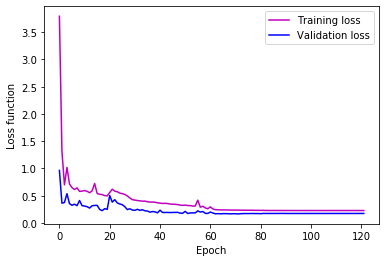

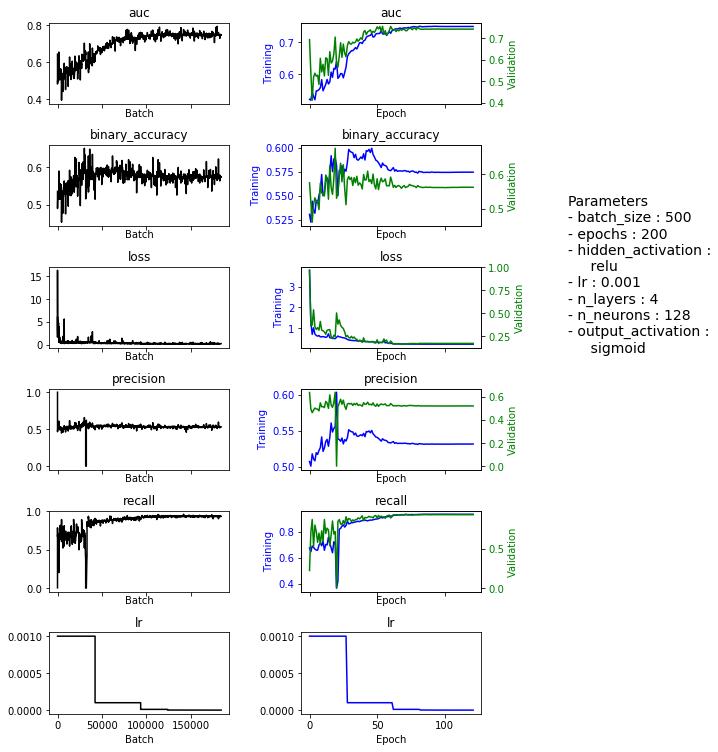

In [22]:
from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(history.history['loss'],color='m',label='Training loss')
plt.plot(history.history['val_loss'],color='b',label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss function')
plt.legend(loc='upper right')
fig.savefig('training_validation.pdf')

PlotHistory(loss_history,params=parameters)
# Params is a dict of parameters with name and values
# used for plotting


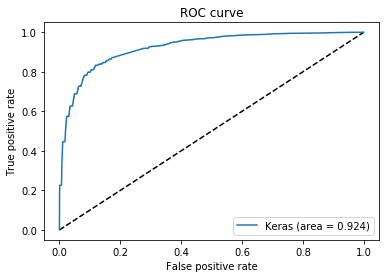

In [23]:
prediction = model.predict(X_test)
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, prediction,sample_weight=w_test)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

from IPython import embed
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
#plt.plot(fpr_rf, tpr_rf, label='XGBoost (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
fig.savefig("ROC_curve.pdf")
plt.show()


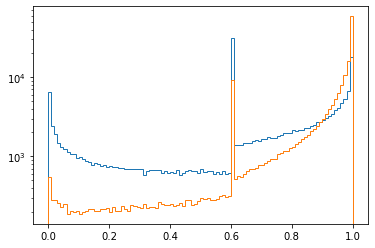

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(prediction[y_test==0],histtype=("step"),bins=100)
plt.hist(prediction[y_test==1],histtype=("step"),bins=100)
plt.yscale('log') 
fig.savefig("prediction.pdf", dpi = 300)

In [ ]:
# evaluate the model
scores = model.evaluate(X_test, y_test, sample_weight=w_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

In [ ]:
# save model and architecture to single file
model.save("model_dnn_threesignal")
print("Saved model to disk")